# Imports and Useful Methods

In [12]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym.wrappers as gw
#device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
from collections import deque 
import copy
from random import randrange
from torchsummary import summary
from tqdm import tqdm

# 1) Random Agent


## Implementation

In [8]:
# Agent that makes moves at random
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.data = [] # Index i represents the distance traveled by the agent 
                       # at iteration i of the last call to run
        
    # Runs the RandomAgent for iters iterations
    def run(self, iters):
        print("Training initialized for {} episodes".format(iters))
        self.clearData()
        for i in range(iters):
            done = False
            info = None
            env.reset()
            reward = 0
            while not done: # Runs until the environment determines a singular game has ended
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                reward += reward
                done = terminated or truncated
            print("Episode {} reward: {}".format(i + 1, reward))
            self.data.append(reward)
    
    def getData(self):
        return self.data
    
    def clearData(self):
        self.data = []

## Performance calculator

#### Use the total reward gained by the agent for a performance metric

Training initialized for 10 episodes
Episode 0 reward: -30
Episode 1 reward: -30
Episode 2 reward: -30
Episode 3 reward: -30
Episode 4 reward: -30
Episode 5 reward: -30
Episode 6 reward: -30
Episode 7 reward: -30
Episode 8 reward: -30
Episode 9 reward: -30


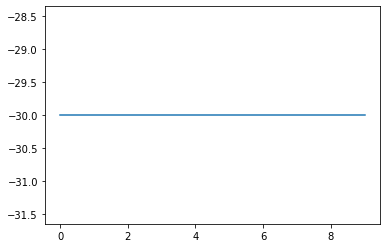

In [7]:
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

ra = RandomAgent(env)
ra.run(10)
env.close()
data = ra.getData()

plt.plot(data)
plt.show()



# 2) Double Deep Q Learning CNN

### Preprocessing the environment

In [2]:
env = gym.make('SuperMarioBros-v0')#, apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = gw.GrayScaleObservation(env, keep_dim=True)
# Resizing the environment
env = gw.ResizeObservation(env, (84, 84))
# Stacking frames for context
env = gw.FrameStack(env, 4)

## Replay buffer holds experiences that the network will use for action replay and batch training

In [3]:
class ReplayBuffer:
    def __init__(self, memory_size=20000):
        self.state = deque(maxlen=memory_size)
        self.action = deque(maxlen=memory_size)
        self.reward = deque(maxlen=memory_size)
        self.next_state = deque(maxlen=memory_size)
        self.done= deque(maxlen=memory_size)

    def append(self, state, action, reward, next_state, done):
        self.state.append(state)
        self.action.append(action)
        self.reward.append(reward)
        self.next_state.append(next_state)
        self.done.append(done)

    def __len__(self):
        return len(self.done)

## Double Deep Q Learning Network using a Convolutional Neural Network

In [30]:
class DDQNetwork():
    def __init__(self, env, alpha = .0001, epsilon = 1, epsilon_decay = .9999, gamma = .99, batch_size = 32,
                 update_f = 4, target_update_f = 1024, memory=20000, input_c = 4, n_actions = 7):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.update_f = update_f
        self.target_update_f = target_update_f
        self.memory = ReplayBuffer(memory)
        self.input_c = input_c
        self.n_actions = n_actions
        
        self.conv1 = nn.Conv2d(input_c, 32, kernel_size=6, stride=3) # Produces 27x27x32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2) # Produces 13x13x64
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # Produces 11x11x64
        self.bn3 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11*11*64, 256) # Fully connected layer
        self.fc2 = nn.Linear(256, self.n_actions)
        
        self.model = nn.Sequential(self.conv1, self.bn1, nn.ReLU(), self.conv2, 
                                   self.bn2, nn.ReLU(), self.conv3, self.bn3, nn.ReLU(), nn.Flatten(), 
                                   self.fc1, nn.ReLU(), self.fc2)
        self.target_model = copy.deepcopy(self.model)
        
        self.currentEpochLoss = []
    
    def get_model(self):
        return self.model
    
    def get_target_model(self):
        return self.target_model
    
    # Adds a transition to the memory for use in the action replay
    def add_memory(self, state, action, reward, next_state, done):
        self.memory.append(state, action, reward, next_state, done)
    
    #Epsilon greedy exploration strategy
    def get_action(self, state):
        if randrange(0,1) < self.epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.model(state)[0])
        
    # Returns the best action for a given state
    def act(self, state):
        return T.argmax(self.model(self.state_to_tensor(state))[0]).item()
    
    # Converts an env state to a valid tensor
    def state_to_tensor(self, state):
        return T.FloatTensor(np.array(state)).permute(3, 0, 1, 2)

    # Trains the network for n epochs, where each epoch has n max_actions   
    def train(self, epochs, max_actions):
        for i in range(epochs):
            print("Epoch {} starting with epsilon {}".format(i + 1, self.epsilon))
                
            total_reward = 0
            
            # Resets the environment
            state = env.reset()
            
            for j in tqdm (range(max_actions), desc="Epoch {}".format(i + 1)):
                action = self.get_action(state)
                
                next_state, reward, done, _ = env.step(action)

                env.render(mode="human")
                total_reward += reward
                self.add_memory(state, action, reward, next_state, done)
            
                if j % self.update_f == 0:
                    self.actionReplay()
                
                if j % self.target_update_f == 0:
                    self.target_model = copy.deepcopy(self.model)
                    
                state = next_state
                
                if done:
                    break
            self.epsilon = max(.01, self.epsilon * self.epsilon_decay)
            print("Epoch {} finished with a reward of {} and average loss of {}"
                  .format(i + 1, total_reward, sum(self.currentEpochLoss) / len(self.currentEpochLoss)))
            self.currentEpochLoss = []
                
                    
    
    def actionReplay(self):
        indices = np.random.choice(range(len(self.memory)), size=self.batch_size)
        
        states = np.array([self.memory.state[i] for i in indices])
        actions = np.array([self.memory.action[i] for i in indices])
        rewards = np.array([self.memory.reward[i] for i in indices])
        next_states = np.array([self.memory.next_state[i][0] for i in indices])
        done = np.array([self.memory.done[i] for i in indices])
        
        # Loop completes one batch of action replay
        for i in range(0, len(states)):
            s = self.state_to_tensor(states[i])
            preds = self.model(s)
            target_preds = self.target_model(s)
        
            loss = nn.MSELoss() # Mean Squared Error Loss
            optimizer = optim.Adam(self.model.parameters(), self.alpha)
        
            if done[i]:
                preds[0][actions[i]] = rewards[i]
            else:
                preds[0][actions[i]] = rewards[i] + self.gamma * (T.max(target_preds))
                
            optimizer.zero_grad()
            output = loss(preds, target_preds)
            self.currentEpochLoss.append(output)
            output.backward()
            optimizer.step()  
    
    def saveModel(self, path):
        T.save(self.model, path)
        T.save(self.target_model, "t_" + path)
        print("Successfully save model to {}".format(path))
        
    def loadModel(self, path):
        self.model = T.load(path)
        self.target_model = T.load("t_" + path)
        print("Successfully loaded model at {}".format(path))

## Agent that uses a trained DDQN for determining optimal policy

In [31]:
class DDQAgent:
    def __init__(self, env, model):
        self.env = env
        self.model = model
        self.data = [] # Index i represents the distance traveled by the agent 
                       # at iteration i of the last call to run
        
    # Runs the DDQAgent iters times
    def run(self, iters):
        self.clearData()
        for i in range(iters):
            done = False
            info = None
            obs = env.reset()
            t_reward = 0
            while not done: # Runs until the environment determines a singular game has ended
                action = model.act(obs)
                obs, reward, terminated, info = env.step(action)
                t_reward += reward
                done = terminated
                env.render(mode="human")
            print("Episode {} reward: {}".format(i + 1, t_reward))
            self.data.append(reward)
    
    def getData(self):
        return self.data
    
    def clearData(self):
        self.data = []

In [ ]:
model = DDQNetwork(env)
model.train(50000, 500)
model.saveModel("smb_1.pt")

Epoch 1 starting with epsilon 1


Epoch 1: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s]


Epoch 1 finished with a reward of 529.0 and average loss of 0.6393972039222717
Epoch 2 starting with epsilon 0.9999


Epoch 2:  89%|████████▉ | 446/500 [01:27<00:10,  5.09it/s]


Epoch 2 finished with a reward of 712.0 and average loss of 0.5896204113960266
Epoch 3 starting with epsilon 0.9998000100000001


Epoch 3:  60%|██████    | 301/500 [00:55<00:38,  5.19it/s]

In [49]:
model = DDQNetwork(env)
model.loadModel("smb_1.pt")
a = DDQAgent(env, model)
a.run(1)
env.close()
data = a.getData()

plt.plot(data)
plt.show()

Successfully loaded model at smb_1.pt


KeyboardInterrupt: 